# Exploratory Analysis of Import Data

In [1]:
#import libraries
import pandas as pd
import polars as pl
import os
import sys
import time
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns


#display settings
pd.set_option('display.max_columns', None)
%matplotlib inline

In [2]:
columns = ['bol_id', 'date_arrival', 'carrier_scac', 'teus', 'weight', 'value_est', 'departure_port_code', 'arrival_port_code', 'vessel_name', 'container_piece_count', 'commod_short_desc', 'commod_short_desc_qty']

In [7]:
pldf = (
    #scan dataset
    pl.scan_parquet('data/piers_imports_complete.parquet', parallel='columns', low_memory=True)
    #select columns
    .select(pl.col(['bol_id', 'date_arrival', 'carrier_scac', 'teus', 'weight', 'value_est', 
                    'departure_port_code', 'arrival_port_code', 'vessel_name', 'container_piece_count',
                    'commod_short_desc', 'commod_short_desc_qty']))
    #collect dataset
    .collect()
    #convert to pandas
    .to_pandas()
    )

In [8]:
pldf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204213186 entries, 0 to 204213185
Data columns (total 12 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   bol_id                 object        
 1   date_arrival           datetime64[ns]
 2   carrier_scac           object        
 3   teus                   float64       
 4   weight                 float64       
 5   value_est              float64       
 6   departure_port_code    object        
 7   arrival_port_code      object        
 8   vessel_name            object        
 9   container_piece_count  int64         
 10  commod_short_desc      object        
 11  commod_short_desc_qty  object        
dtypes: datetime64[ns](1), float64(3), int64(1), object(7)
memory usage: 18.3+ GB


## Duplicate BOLs 

In [10]:
#get df including all rows where bol_id occurs on more than one row
dup_bols_df = pldf[pldf.bol_id.duplicated(keep=False)]

In [14]:
#get proportion of these rows that have different carrier_scac codes
dup_bols_df['bol_id'][dup_bols_df.carrier_scac.duplicated(keep=False)==False].info()

<class 'pandas.core.series.Series'>
Index: 20 entries, 18132339 to 161534003
Series name: bol_id
Non-Null Count  Dtype 
--------------  ----- 
20 non-null     object
dtypes: object(1)
memory usage: 320.0+ bytes


~ 13% of rows list bol numbers that occur elsewhere in the dataset. 

Possible reasons:
- bol includes items on more than one ship
- bol not unique across carriers (only 20 entries have duplicate bol_ids but different carrier_scac, so this isn't the main reason)

## Entries with zero weight:

In [16]:
pldf[pldf.weight == 0].describe()

,date_arrival,teus,weight,value_est,container_piece_count
count,93886948,9.388695e+07,93886948.0,93886948.0,9.388695e+07
mean,2009-10-17 03:11:48.945215232,2.200700e-05,0.0,0.0,1.441126e+00
min,2005-01-01 00:00:00,0.000000e+00,0.0,0.0,0.000000e+00
25%,2007-05-22 00:00:00,0.000000e+00,0.0,0.0,1.000000e+00
50%,2009-07-25 00:00:00,0.000000e+00,0.0,0.0,1.000000e+00
75%,2012-04-10 00:00:00,0.000000e+00,0.0,0.0,1.000000e+00
max,2023-11-13 00:00:00,3.400000e+01,0.0,0.0,9.990000e+02
std,NaN,1.059935e-02,0.0,0.0,3.878725e+00


In [18]:
pldf.describe()

,date_arrival,teus,weight,value_est,container_piece_count
count,204213186,2.042132e+08,2.042132e+08,2.042132e+08,2.042132e+08
mean,2015-01-29 21:53:29.736486400,1.126241e+00,4.152496e+04,6.839881e+04,1.444714e+00
min,2005-01-01 00:00:00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2010-02-04 00:00:00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
50%,2015-06-30 00:00:00,1.000000e-01,2.500000e+02,1.192000e+03,1.000000e+00
75%,2020-02-20 00:00:00,2.000000e+00,1.205300e+04,3.747600e+04,1.000000e+00
max,2023-11-30 00:00:00,1.730750e+03,6.172936e+09,9.981402e+09,9.990000e+02
std,NaN,2.943881e+00,1.611364e+06,2.670985e+06,3.490885e+00


## Value and Volumes by Year:

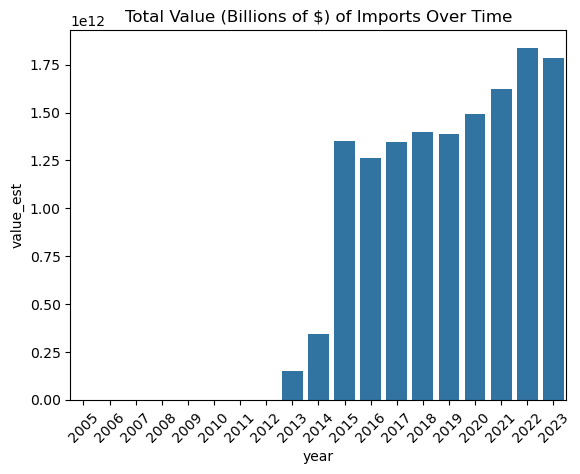

In [37]:
#get year col
pldf['year'] = pldf.date_arrival.dt.to_period('Y')
#group value and volume by year
activityacrosstime_df = pldf[['year', 'teus', 'value_est']].groupby('year').sum()
#plot
sns.barplot(data=activityacrosstime_df, x='year', y='value_est');
plt.title('Total Value (Billions of $) of Imports Over Time')
plt.xticks(rotation=45);

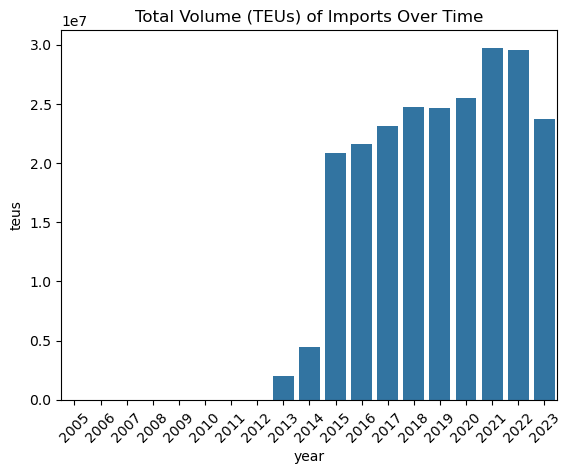

In [38]:
#plot
sns.barplot(data=activityacrosstime_df, x='year', y='teus');
plt.title('Total Volume (TEUs) of Imports Over Time')
plt.xticks(rotation=45);

I guess value and volume records weren't kept before ~2015 ?!?

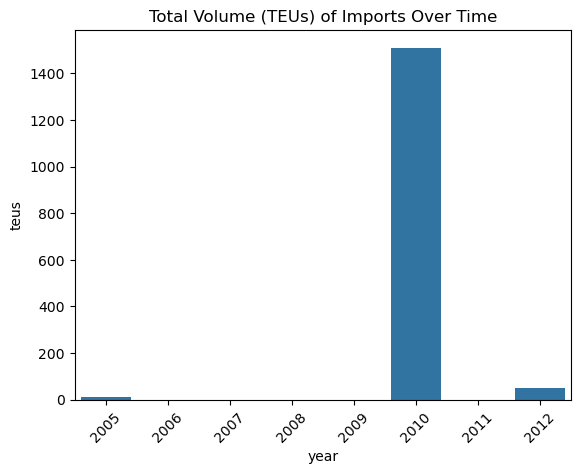

In [51]:
#group value and volume by year
until2012_df = pldf[pldf['year']< pd.Period(2013)]
until2012_df = until2012_df[['year', 'teus', 'value_est']].groupby('year').sum()
#plot
sns.barplot(data=until2012_df, x='year', y='teus');
plt.title('Total Volume (TEUs) of Imports Over Time')
plt.xticks(rotation=45);

Must be missing data here?

## 